<h2 style="color:#003f5b">Is Washington State residential per capita electricity consumption on the decline?</h2>

Energy efficiency is a hot topic in the electricity industry. If you read Integrated Resource Plans (IRPs) you will see that energy efficiency is often one of the cheapest resources that can be used to meet new incremental load growth which is why many utilities have invested so heavily into efficiency programs. Utilities have sponsored efficiency programs for decades but more recently changes in appliance standards, building codes and technlogical innovation have created a paradigm shift. Energy Intensity, especially in the residential sector, has been on the decline since the great recession.

Reports of declining electricity sales per household isn't news to those in the electricity industry but the trend has gained more mainstream attention in recent years. For a good primer check ou this EIA article https://www.eia.gov/todayinenergy/detail.php?id=32212 or this Berkley blog: http://blogs.berkeley.edu/2017/05/08/evidence-of-a-decline-in-electricity-use-by-u-s-households/.

Taking some inspiration from the EIA and Berkley pieces, I thought it would be interesting to examine Washington State per capita electricity sales to see how strongly this declining trend presented itself at a state level. To make things a little more interesting I also decided to play around with 3 different smoothing methods to adjust for year-to-year weather variation, which is important since the Northwest experienced unusually warm weather from 2014-2016:

1. A LOWESS smoother: http://www.statsmodels.org/dev/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html
2. Statsmodels TSA seasonal decomposition: http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
3. Facebook's forecasting package Prophet: https://research.fb.com/prophet-forecasting-at-scale/

I wanted an excuse to test out Facebook's Prophet model and seasonal detrending seemed like a good use case.

<h2 style="color:#003f5b">Importing Packages</h2>

We'll import a handful of packages here. I've got a local script to pull data from the EIA API which you can find on my github: https://github.com/johnmrudolph/jupyter_blog/blob/master/scripts/eiapi.py. Most of the other packages are pretty vanilla but I'll call attention to fbprophet since this is Facebook's forecasting package and might be unfamiliar.

In [1]:
# import local script
import sys
sys.path.insert(0, '/home/john/jupyter_blog/jupyter_blog/scripts')

import numpy as np
import pandas as pd
import statsmodels.api as sm
import eiapi as epi
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from fbprophet import Prophet
%matplotlib inline
plt.style.use('bmh')

<h2 style="color:#003f5b">Pulling Washington Residential Consumption and Population Data</h2>

Here we'll make a call to the EIA api. We're requesting 2 series:
1. Washington State Residential Electricity Sales: ELEC.SALES.WA-RES.M
2. Washington State Annual Population

For more detail on how the API call to EIA work see this quick article I wrote up: 
https://github.com/johnmrudolph/jupyter_blog/blob/master/working_with_apis.ipynb.

In [2]:
# can be obtained from EIA here: http://www.eia.gov/opendata/register.php
api_key = '5F4109570C68FDE20F42C25F5152D879'
# start and end dates for beginning and end of time series
start = '2001-01-01 01:00:00'
end = '2016-12-31 23:00:00'
# must specify that frequency is annual'A' for datetime conversion
freq = 'A'

# full list of available series is here: http://www.eia.gov/opendata/qb.php?category=2122628
keys = ['ELEC.SALES.WA-RES.M', 'SEDS.TPOPP.WA.A']

# create dict of GetSeriesRange objects from series list
series_dict = {key: epi.GetSeries(api_key=api_key, series_id=key, 
                                    start=start, end=end, freq=freq) for key in keys}

INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): api.eia.gov
INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): api.eia.gov


# Print Returned Data

In [3]:
for key in series_dict:
    print('Series Name {} \n Units: {} \n Key {}'.format(series_dict[key].data.series[0]['name'], 
                             series_dict[key].data.series[0]['units'], key))

Series Name Resident population including Armed Forces, Washington 
 Units: Thousand 
 Key SEDS.TPOPP.WA.A
Series Name Retail sales of electricity : Washington : residential : monthly 
 Units: million kilowatthours 
 Key ELEC.SALES.WA-RES.M


# Graph Series

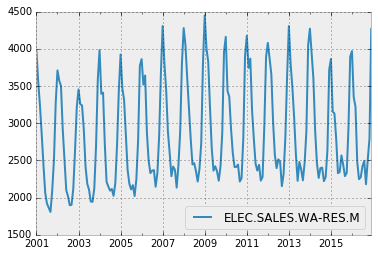

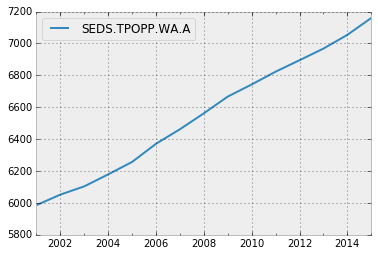

In [4]:
# create new data frames
wa_sales = series_dict['ELEC.SALES.WA-RES.M'].data.df.sort_index()
wa_pop = series_dict['SEDS.TPOPP.WA.A'].data.df.sort_index()

# convert index to datetime
wa_sales.index = pd.to_datetime(wa_sales.index)
wa_pop.index = pd.to_datetime(wa_pop.index)

# plot total washington residential electricity sales and population
wa_sales.plot()
wa_pop.plot()

# Plot Per Capita Washington Consumption

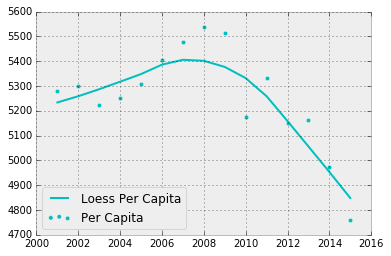

In [9]:
# Group sales data to annual, merge with population series and create per capita
wa_sales_annual = wa_sales.groupby(pd.Grouper(freq='A'))['ELEC.SALES.WA-RES.M'].agg(['sum'])
wa_sales_annual['year'] = wa_sales_annual.index.to_period('A')
wa_pop['year'] = wa_pop.index.to_period('A')
wa_merged = pd.merge(wa_sales_annual, wa_pop, on='year')
wa_merged['year'] = wa_merged['year'].astype(str).astype(int)
wa_merged['per_capita'] = wa_merged['sum']*1000/wa_merged['SEDS.TPOPP.WA.A']

# Create Loess of Per Capita
wa_merged['per_capita_loess'] = sm.nonparametric.lowess(
    wa_merged['per_capita'], wa_merged['year'], return_sorted=False)

# Graph Smoothed Electricity Sales Per Capita
plt.scatter(wa_merged['year'], wa_merged['per_capita'], c='c', label='Per Capita')
plt.plot(wa_merged['year'], wa_merged['per_capita_loess'], c='c', label='Loess Per Capita')
plt.legend(loc=3)
plt.show()

# Deseasonalize Electricity Sales Data

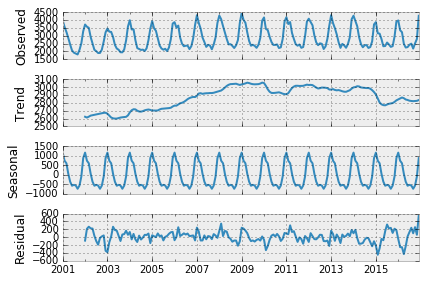

In [10]:
# Run seasonal decomposition and plot
wa_sales_decompose = sm.tsa.seasonal_decompose(wa_sales, two_sided=False)
decmpose_plot = wa_sales_decompose.plot()

# Extract deseasonlized trend and aggregate to annual frequency

In [11]:
# Create a filtered series : trend 
wa_sales_tsa = wa_sales_decompose.trend
# Group deaseasonalized sales trend by year
wa_sales_tsa_annual = wa_sales_tsa.groupby(
    pd.Grouper(freq='A'))['ELEC.SALES.WA-RES.M'].agg(['sum','count'])
# Drop years where there isn't 12 months of filtered data
wa_sales_tsa_annual = wa_sales_tsa_annual[wa_sales_tsa_annual['count']==12]
wa_sales_tsa_annual.drop('count', axis=1, inplace=True)

# Join TSA Detrended Consumption and Population Data

In [27]:
# create annual key and merge sales and population dfs
wa_sales_tsa_annual['year'] = wa_sales_tsa_annual.index.to_period('A')
wa_tsa_merged = pd.merge(wa_sales_tsa_annual, wa_pop, on='year')
# coerce year datetime to int
wa_tsa_merged['year'] = wa_tsa_merged['year'].astype(str).astype(int)
# create per_capita sales variable
wa_tsa_merged['per_capita'] = wa_tsa_merged['sum']*1000 / wa_tsa_merged['SEDS.TPOPP.WA.A']

# Plot deseasonalized per capita consumption

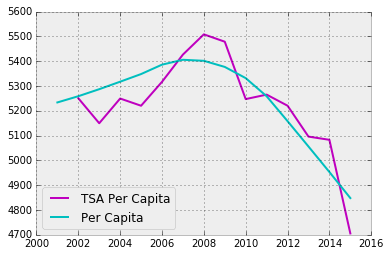

In [28]:
plt.plot(wa_tsa_merged['year'], wa_tsa_merged['per_capita'], c='m', label='TSA Per Capita')
plt.plot(wa_merged['year'], wa_merged['per_capita_loess'], c='c', label='Per Capita')
plt.legend(loc=3)
plt.show()

# Deseasonalize Using Facebook Prophet

In [17]:
# Prophet requires independent (y) and Datetime (ds) inputs vars in dataframe
df = pd.DataFrame(columns=['y','ds'])
df['ds'] = wa_sales.index
df['y'] = wa_sales['ELEC.SALES.WA-RES.M'].values

# fit the prophet model
m = Prophet().fit(df)
future = m.make_future_dataframe(periods=0, freq='M')
fcst = m.predict(future)
fcst.index = fcst['ds'].values

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Extract deseasonalized trend and aggregate to annual frequency

In [18]:
# group deaseasonalized sales trend by year
wa_sales_proph = fcst.groupby(pd.Grouper(freq='A'))['trend'].agg(['sum','count'])
# unlike tsa.seasonal decompose there are no obs dropped from historical time series
# but we'll apply the filter anyways and drop the count variable
wa_sales_proph_annual = wa_sales_proph[wa_sales_proph['count']==12]
wa_sales_proph_annual.drop('count', axis=1, inplace=True)

# Join Prophet Detrended Consumption and Population Data

In [19]:
# create annual key and merge sales and population dfs
wa_sales_proph_annual['year'] = wa_sales_proph_annual.index.to_period('A')
wa_proph_merged = pd.merge(wa_sales_proph_annual, wa_pop, on='year')
# coerce year datetime to int
wa_proph_merged['year'] = wa_proph_merged['year'].astype(str).astype(int)
# create per_capita sales variable
wa_proph_merged['per_capita'] = (wa_proph_merged['sum']*1000 / 
                                   wa_proph_merged['SEDS.TPOPP.WA.A'])

# Plot prophet per capita vs tsa per capita

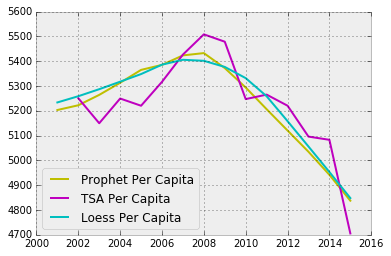

In [26]:
plt.plot(wa_proph_merged['year'], wa_proph_merged['per_capita'], c='y', label='Prophet Per Capita')
plt.plot(wa_tsa_merged['year'], wa_tsa_merged['per_capita'], c='m', label='TSA Per Capita')
plt.plot(wa_merged['year'], wa_merged['per_capita_loess'], c='c', label='Loess Per Capita')
plt.legend(loc=3)
plt.show()